# Delithiation and obtain the voltages

Delithiate the search results and found find there voltages properly

In [2]:
%aiida
import pandas as pd
from aiida.orm import KpointsData, StructureData

## Read the data

In [3]:
df = pd.read_csv("delithiation-selected.csv")
df.sort_values('e_pa', inplace=True)

In [4]:
df['relaxed_structure'] = df.relax_structure_uuid.apply(lambda x: load_node(x))

## Check how many structures needs to be generated

In [5]:
VaspRelax = WorkflowFactory('vaspu.relax')
from aiida_user_addons.process.transform import _delithiate_unique_sites
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

In [6]:
def refine(ps, atol=1e-5):
    ana = SpacegroupAnalyzer(ps, atol)
    return ana.get_primitive_standard_structure()

In [17]:
minstructures = df.loc[df.groupby(df.formula)['e_pa'].idxmin()]


# Top three structures for each formula
top3 = df.loc[df.groupby(df.formula)['e_pa'].head(3).index]

## Test deploying the calculations

In [10]:
li2feso_relax = load_node("c0b4f19c-d4ba-4b2a-a57d-7f2e5c725da4")  # Previous relaxations of the Li2FeSO structures

In [11]:
def get_delithiate_builder(structure, misc, nsub, kspacing=0.04, code='vasp-5.4.4-std@michael-fw', wallclock=12, extra_incar={}, deli_limit=8):
    from aiida_user_addons.vworkflows.relax import RelaxOptions
    from aiida_user_addons.common.inputset.vaspsets import VASPInputSet
    Deli = WorkflowFactory('vaspu.delithiate')
    builder = Deli.get_builder()
    
    
    builder.relax.vasp.code = Code.get_from_string(code)
    builder.structure = structure
    builder.relax.vasp.kpoints_spacing = kspacing
    if 'archer2' in code:
        builder.relax.vasp.options = Dict(dict={
        'resources': {
            'num_mpiprocs_per_machine': 64,
            'num_machines': 1,
            'tot_num_mpiprocs': 64,

        },
        'max_wallclock_seconds': 3600 * wallclock,
        'import_sys_environment': False,
        'account': 'e05-power-dos',
        'qos': 'standard',
        'queue_name': 'standard',
        'mpirun_extra_params': ['--cpu-bind=rank', '--hint=nomultithread', '--distribution=block:block']
    })
    else:
        builder.relax.vasp.options = Dict(dict={
            'resources': {
                'tot_num_mpiprocs': 24,

            },
            'max_wallclock_seconds': 3600 * wallclock,
            'priority': "101",
        })
    
    overrides = {'lwave': False, 'gga': 'pe', 'encut': 520,} #'potim': 0.2}
    overrides.update(extra_incar)
    
    incar = VASPInputSet("UCLRelaxSet", structure, overrides)

    builder.relax.vasp.parameters = Dict(dict={'incar': incar.get_input_dict()})
    builder.relax.vasp.potential_family = Str("PBE.54")
    builder.relax.vasp.potential_mapping = Dict(dict=incar.get_pp_mapping())

    builder.relax.relax_settings = RelaxOptions(algo='cg', reuse=False).to_aiida_dict()

    builder.strategy = Str('unique')
    builder.rattle_amp = Float(0.1)
    builder.run_initial_relax = Bool(False)
    
    builder.unique_options.excluded_sites = List(list=[])
    builder.unique_options.nsub = Int(nsub)
    builder.unique_options.atol = Float(1e-3)
    builder.unique_options.limit = Int(deli_limit)

    builder.ldau_mapping = Dict(dict={'mapping': {'Fe': ['d', 4.0]}})
    builder.deli_magmom_mapping = Dict(dict={'Fe': 5.0})
    
    if misc is not None:
        builder.lithiated_calc_output = misc
    builder.metadata.label = structure.label + ' GGA+U DELI'
    return builder

## Launch the workchains

## Launch for the Li4Fe3S3O2 structure

In [12]:
from aiida.engine import submit

In [10]:
li4fe3s3o2_enum = load_node('d6474c74-bb0f-4f18-bc0c-7d0287762989')

#li4fe3s3o2_enum.label = 'Li4Fe3S3O4 Enum minimum'

## Launch for other structures obtained via mode pushing

In [7]:
li2fe3s2o2_mode_pushed = load_node('bc8867ff-c442-4b59-b264-9311d0d29156')
li2fe2s2o_pushed = load_node('3e0e99da-2a70-4c12-b59f-42cba5bfcba5')
li2fe4s3o2_pushed = load_node('d270e70c-7286-4244-b9bb-7e3524526c2e')

### Results for the pushed phases

In [23]:
relax_work = load_node('575966')

In [24]:
relax_work

<WorkChainNode: uuid: b21e761e-50da-4658-b6ce-eb5ca30b0bd7 (pk: 575966) (aiida.workflows:vaspu.relax)>

In [22]:
q = QueryBuilder()
q.append(Node, filters={'id': li2fe4s3o2_pushed.id})
q.append(WorkflowFactory('vaspu.delithiate'), tag='deli', project=['id'])
#q.append(Dict, project=['attributes'], edge_filters={'label': {'like': '%voltages'}})
q.append(Dict, project=['attributes'], with_incoming='deli', edge_filters={'label': 'output_parameters'})
q.all()

[[575965,
  {'energy': [-52.264495025],
   'relax_id': [0],
   'relaxation': ['1b9dd176-4a78-48d4-b56d-8f661bb0a2d3'],
   'delithiate_id': [0],
   'magnetisation': [[33.3342543]],
   'deli_link_label': ['result'],
   'input_structure': ['04112d4d-05a5-43c3-a291-29b0abbacfb0'],
   'output_structure': ['b2b33811-295b-47cf-8279-983010061e24'],
   'total_magnetisation': [16.66712715]}]]

## Comments

1. Testing the workchain with Li2FeSO - test OK 
2. Proceed with delithiating the minimum energy structure for each composition
3. Top3 structures for each formula submitted
4. Should use CG (ibrion=2) instead of the RD (ibrion=1) the latter essentially not work

Launched delithiation for the lowest energy structure for Li4Fe3S3O2 obtained using enumeration + Ewald summation. 12/04/2021

## Delithiation results

In [8]:
group = Group.objects.get(label='li-fe-o-f/delithiation-starting-relaxes')

In [11]:
q = QueryBuilder()
q.append(Group, filters={'id': group.pk})
q.append(Node, with_group=Group, project=['label', 'uuid'])
q.append(StructureData, project=['label', 'uuid', '*'])
q.append(WorkflowFactory('vaspu.delithiate'), tag='deli', project='uuid')
q.append(Dict, project=['attributes'], edge_filters={'label': {'like': '%voltages'}})
q.append(Dict, project=['attributes'], with_incoming='deli', edge_filters={'label': 'output_parameters'})

q.all()

voltage_data = pd.DataFrame(q.all(), columns=['relax_label', 'relax_uuid', 'struct_label', 'struct_uuid', 'struct', 'deli_uuid', 'voltage_dict', 'deli_data'])
voltage_data['voltages'] = voltage_data.voltage_dict.apply(lambda x: x['voltage'])

voltage_data['min_voltages'] = voltage_data['voltages'].apply(lambda x: min(x))
voltage_data['avg_voltages'] = voltage_data['voltages'].apply(lambda x: np.mean(x))

voltage_data = voltage_data.merge(df, on='relax_uuid', how='left')
voltage_data = voltage_data.loc[voltage_data.groupby('formula').e_above_hull.idxmin()]

mean_voltages = voltage_data.groupby('formula').avg_voltages.mean()
min_voltages = voltage_data.groupby('formula').min_voltages.min()
above_hull = voltage_data.groupby('formula').e_above_hull.min()

In [15]:
voltage_data.deli_uuid.to_list()

['6e026ea5-0687-4559-b0dc-e18c1373a67d',
 '834fe9a4-5a7b-4f0f-9ce9-82416a2f1be7',
 '952b260a-37d9-41f5-8c42-4c628682eef1',
 '1d727e34-9367-4628-b0f8-1688ff430369',
 '86b7066b-ef64-4abe-8b76-cc776506893d',
 '1faf7138-e2e9-4c41-96a4-a3d5b2436661',
 '3b8edea7-b3e4-4500-82e5-7664220a2c44',
 'e5aa54b1-31cf-4283-985a-6e8361dfe5dd',
 'fc3028cd-8a72-439e-9d0f-1db52df50de6',
 'de82dcb5-6836-4942-8002-ed003f6dacba',
 'fdb87eb0-8383-431d-902d-70e777aa01ef']

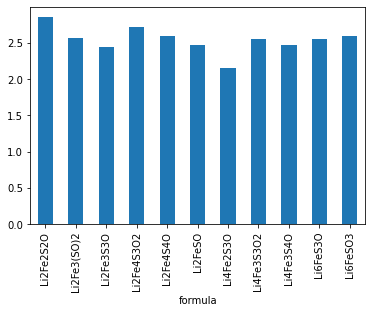

In [192]:
mean_voltages.plot.bar()

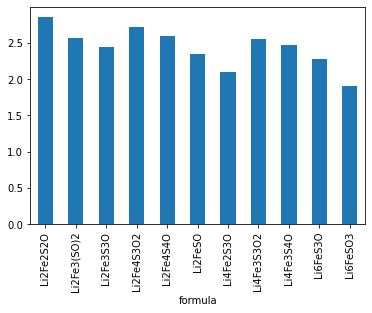

In [193]:
min_voltages.plot.bar()

In [194]:
voltage_formula = pd.concat([min_voltages, mean_voltages, above_hull], axis=1)

(1.5, 3.0)

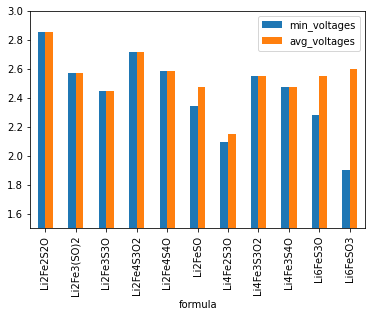

In [195]:
ax = voltage_formula.plot.bar(y=['min_voltages', 'avg_voltages'])
ax.set_ylim(1.5, 3.0)

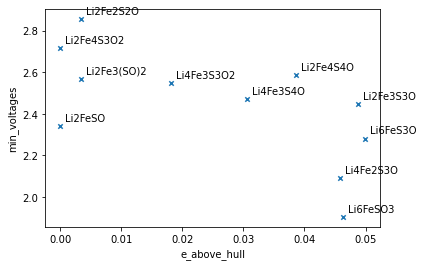

In [196]:
ax = voltage_formula.plot.scatter(x='e_above_hull', y='min_voltages', marker='x')

for form, row in voltage_formula.iterrows():
    ax.annotate(form, (row.e_above_hull, row.min_voltages), (5, 5), textcoords='offset points')

## Assemble a table

Shows the best structure of each compositions and its energy above hull value, the voltage (min) and the volume change,
expected current density and the energy density

In [251]:
from toolchest.battery.metrics import TheoreticalCathode
from pymatgen import Composition

def compute_capacity(row):
    """Compute the capacity"""
    comp = Composition(row.formula)
    nli = min(comp['Fe'], comp['Li'])
    cathode = TheoreticalCathode(comp, nli=nli, avg_voltage=row.min_voltages, label=row.formula)
    return cathode.mAhg, cathode.Whkg

In [198]:
most_stable = voltage_data.loc[voltage_data.groupby('formula')['e_above_hull'].idxmin()]

In [264]:
records = []
indices = []
for idx, row in most_stable.iterrows():
    deli_data = row.deli_data
    voltage_data = row.voltage_dict
    imin = np.argsort(voltage_data['voltage'])[0]
    ideli = len(voltage_data['voltage'])
    vols = []
    for i in range(ideli):
        inp = load_node(deli_data['input_structure'][i])
        out = load_node(deli_data['output_structure'][i])
        vols.append((out.get_cell_volume() - inp.get_cell_volume()) / inp.get_cell_volume())
    mahg, whkg = compute_capacity(row)
    records.append([vols[imin], voltage_data, mahg, whkg])
    indices.append(idx)
extra_prop = pd.DataFrame(records, columns=['volume_change', 'voltage_data', 'mAh/g', 'Wh/kg'], index=indices)

In [265]:
output = pd.concat([most_stable, extra_prop], axis=1)

In [266]:
output[['formula', 'min_voltages', 'volume_change', 'e_above_hull', 'mAh/g', 'Wh/kg', 'decomp', 'min_volt_relax']].sort_values('e_above_hull')

,formula,min_voltages,volume_change,volume_change,e_above_hull,mAh/g,Wh/kg,decomp,min_volt_relax
28,Li2FeSO,2.339523,-0.044623,-0.044623,0.000000e+00,227.533431,532.319773,Li2FeSO,2d9b9537-1843-4518-9abc-5d2f85f0ea15
13,Li2Fe4S3O2,2.716773,-0.073478,-0.073478,8.881784e-16,146.674270,398.480714,Li2Fe4S3O2,3d24b13d-1a48-41e6-a9f2-d6550e72e5d4
17,Li2Fe3(SO)2,2.567981,-0.100118,-0.100118,3.356444e-03,193.131954,495.959166,Li2FeSO+FeO+Li2Fe4S3O2,a226a5ae-d3f5-4403-9a8a-9703ab39b668
24,Li2Fe2S2O,2.853666,-0.116797,-0.116797,3.385171e-03,260.586281,743.626164,Li2Fe4S3O2+Li2S,62a7e398-50a7-49b9-b4ec-b85f1a88f637
12,Li4Fe3S3O2,2.549100,-0.033542,-0.033542,1.807660e-02,248.550954,633.581231,Li2FeSO+Li2Fe4S3O2+Li2S,5e51e723-f0c1-4212-9546-a8c146f6de9b
3,Li4Fe3S4O,2.472016,-0.037815,-0.037815,3.053905e-02,236.791209,585.351645,Li2Fe4S3O2+FeS+Li2S,2f6e776a-a2e6-4a42-a564-7481598f3a3d
0,Li2Fe4S4O,2.586309,-0.069035,-0.069035,3.862633e-02,140.497919,363.370995,Li2Fe4S3O2+FeS+Li2S,ab38fb52-7685-4494-b009-28deaa7ca2b3
4,Li4Fe2S3O,2.091393,-0.055008,-0.055008,4.579586e-02,213.007366,445.482127,Li2Fe4S3O2+Li2S,48922a50-da4b-4cc3-acd4-94038c64bdfb
6,Li6FeSO3,1.903522,-0.099812,-0.099812,4.629966e-02,150.948169,287.333230,Li2O+Li2FeO2+Li2S,a4564dd1-9248-4b23-bf9b-9d011e94f411
20,Li2Fe3S3O,2.445469,-0.075694,-0.075694,4.883292e-02,182.564310,446.455392,Li2Fe4S3O2+FeS+Li2S,b49b89df-c6ef-4f33-99f1-2dec41d2dbf4


In [278]:
def view_deli(row):
    li = row.relaxed_structure.get_ase()
    de = load_node(row.min_volt_relax).outputs.relax__structure.get_ase()
    view([li, de])

In [285]:
view_deli(output.sort_values('e_above_hull').loc[3])